In [1]:
import scipy as sp
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import qutip as qt
from qutip import hinton, identity, to_super, sigmaz, tensor, tensor_contract, sigmax, projection, jmat, basis, propagator, coefficient

In [2]:
Sz = tensor(jmat(1/2,'z'), identity([2]))
Sx = tensor(jmat(1/2,'x'),identity([2]))
Sy = tensor(jmat(1/2,'y'),identity([2]))

Iz = tensor(identity(2), jmat(1/2,'z'))
Ix = tensor(identity(2), jmat(1/2,'x'))
Iy = tensor(identity(2), jmat(1/2,'y'))

In [30]:
sqrt2 = np.sqrt(2)
isqrt2 = 1/np.sqrt(2)

GHz=1e3
MHz=1
kHz=1e-3

ms=1e3
us=1
ns=1e-3

T = 1e4
G = 1

B = 360

gamma_e = -28024 * MHz / T
gamma_p = 42.577 * MHz / T
gamma_N = -4.316 * MHz / T

omegaNV =  2.87 * GHz + gamma_e * B
omegaX = gamma_e * B
omegaN15 = gamma_N * B
omegaP = gamma_p * B

D = 60 * kHz
Omega = 1 * MHz
Omega_p = 40*kHz

T1e = 1*ms
T2e = 4*us
T2e_star = 50*us
T1n = 10*ms
T2n = 500*us

T1e_rho = 100*us # this is emergent, no need to add directly

t_swap_nvx = 7.95*us

deg = np.pi/180

In [4]:
e0 = basis(2,0)
e1 = basis(2,1)
n0 = basis(2,0)
n1 = basis(2,1)

ket00 = tensor(e0,n0)
ket01 = tensor(e0,n1)
ket10 = tensor(e1,n0)
ket11 = tensor(e1,n1)

rho00 = tensor(projection(2,0,0), projection(2,0,0))
rho01 = tensor(projection(2,0,0), projection(2,1,1))
rho10 = tensor(projection(2,1,1), projection(2,0,0))
rho11 = tensor(projection(2,1,1), projection(2,1,1))

In [64]:
e_c_ops = [1/(2*T1e) * Sx, 1/(2*T1e) * Sy, 1/(2*T2e) * Sz]

estar_c_ops = [1/(2*T1e) * Sx, 1/(2*T1e) * Sy, 1/(2*T2e_star) * Sz]

n_c_ops = [1/(2*T1n) * Ix, 1/(2*T1n) * Iy, 1/(2*T2n) * Iz]

lindblad_ops = estar_c_ops + n_c_ops 

In [65]:
def noise(t):
    # computes noise propegator for a time t while no 
    # other evolution is occuring
    return propagator(identity([2,2]), t, c_ops=lindblad_ops)

def partial_pol_state(pol):
    # returns a state partially polarize along Z
    # polarization must be a number between -1 and 1
    assert abs(pol) <= 1
    return (1+pol)/2*projection(2,0,0) + (1-pol)/2*projection(2,1,1)

def nv_reset(pol):
    return tensor(projection(2,0,0), partial_pol_state(pol), prho)

XPi = qt.to_super((-1j*(np.pi)*Sy).expm())



In [66]:
zdir_nv = (1/np.sqrt(3))*np.array([1,1,1])
theta_nv = np.arccos(1/np.sqrt(3))
phi_nv = 45*deg

def EulerMatrix(alpha, beta, gamma):
    return Rz(alpha) @ Ry(beta) @ Rz(gamma)

def Rz(alpha):
    return np.array(
        [
            [np.cos(alpha), -np.sin(alpha),0],
            [np.sin(alpha), np.cos(alpha),0],
            [0,0,1]
        ]
    )

def Ry(alpha):
    return np.array(
        [
            [np.cos(alpha), 0, np.sin(alpha)],
            [0,1, 0],
            [-np.sin(alpha),0, np.cos(alpha)]
        ]
    )

def Rx(alpha):
    return np.array(
        [
            [1,0,0],
            [0, np.cos(alpha), -np.sin(alpha),],
            [0, np.sin(alpha), np.cos(alpha),]
        ]
    )


# magnetic field alignment in the lab frame
theta = 0
phi = phi_nv

# some other relative angles 
alpha = 0*deg
beta = 90*deg

# principle components of uni-axial symm HF tensor
A_perp = 17.2 * MHz
A_para = 29.4 * MHz

# direction of B field in the lab frame
Bdir = np.array([np.sin(theta)*np.sin(phi), np.sin(theta)*np.cos(phi), np.cos(theta)])

# Hyperfine tensor in the principle axis frame
A_principle = np.array([[A_perp, 0, 0], [0, A_perp, 0], [0, 0, A_para]])

RB = EulerMatrix(phi, theta, 0)
RA = EulerMatrix(beta, alpha, 0)

# NV-frame hyperfine tensor
A = RB @ RA.T @ A_principle @ RA @ RB.T

In [67]:
H = (omegaX * Sz + omegaP * Iz + A[2,2] * (Sz * Iz) + A[2,0] * (Sz * Ix) + A[2,1] * (Sz * Iy))
energies = H.eigenenergies()
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-496.315614    0.          0.          0.      ]
 [   0.       -512.548386    0.          0.      ]
 [   0.          0.        497.848386    0.      ]
 [   0.          0.          0.        511.015614]]

In [68]:
omega_cnot_right = (energies[3]-energies[0])

omega_cnot_upper = (energies[3]-energies[2])
omega_cnot_lower = (energies[1]-energies[0])

In [69]:
omega_cnot_right

1023.5640000000001

In [70]:
rho0 = 0.5*tensor(projection(2,0,0), identity([2]))

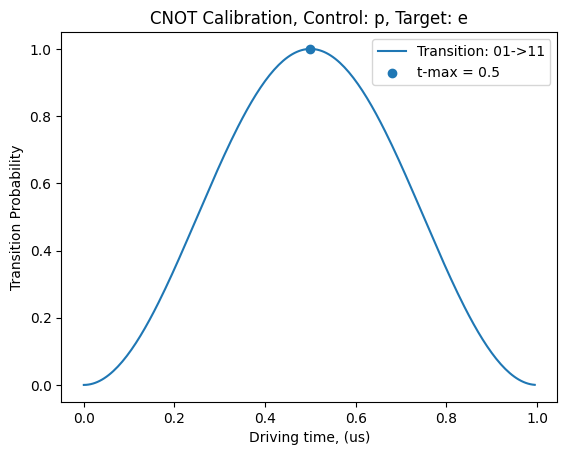

In [156]:
HrE = 2*pi* ((omegaX + omega_cnot_right) * Sz + A[2,2] * (Sz * Iz) + Omega * Sx)

times = np.arange(0,1,.005)
resE = qt.mesolve(HrE,rho01,times,c_ops=lindblad_ops)
signal = [qt.expect(rho11, state) for state in resE.states]
t_cnot_e = times[np.argmax(signal)]
plt.plot(times,signal,label="Transition: 01->11")
plt.scatter(t_cnot_e, np.max(signal),label=f"t-max = {t_cnot_e}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: p, Target: e")
plt.legend()
plt.show()

In [160]:
(omegaX + omega_cnot_right) * Sz + A[2,2] * (Sz * Iz) + Omega * Sx

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.47000000e+01  0.00000000e+00  5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00  2.30926389e-14  0.00000000e+00  5.00000000e-01]
 [ 5.00000000e-01  0.00000000e+00 -1.47000000e+01  0.00000000e+00]
 [ 0.00000000e+00  5.00000000e-01  0.00000000e+00 -2.30926389e-14]]

In [162]:
omegaX

-1008.864

In [163]:
omega_cnot_right

1023.5640000000001

In [161]:
(omegaX + omega_cnot_right)

14.700000000000045

In [157]:
HrE

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 9.23628240e+01  0.00000000e+00  3.14159265e+00  0.00000000e+00]
 [ 0.00000000e+00  1.45095330e-13  0.00000000e+00  3.14159265e+00]
 [ 3.14159265e+00  0.00000000e+00 -9.23628240e+01  0.00000000e+00]
 [ 0.00000000e+00  3.14159265e+00  0.00000000e+00 -1.45095330e-13]]

In [168]:
cnot_e = propagator(HrE, 0.50*us)

In [169]:
cnot_e

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-6.09185161e-01-7.92538433e-01j  0.00000000e+00+0.00000000e+00j
  -1.58171546e-18-2.69570895e-02j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  3.46837316e-12-4.61852778e-14j
   0.00000000e+00+0.00000000e+00j  7.70443789e-30-1.00000000e+00j]
 [ 1.58171546e-18-2.69570895e-02j  0.00000000e+00+0.00000000e+00j
  -6.09185161e-01+7.92538433e-01j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -7.70443789e-30-1.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.46837316e-12+4.61852778e-14j]]

In [138]:
cost_up = coefficient(lambda t: np.cos(omega_cnot_upper*t))
sint_up = coefficient(lambda t: np.sin(omega_cnot_upper*t))

cost_low = coefficient(lambda t: np.cos(omega_cnot_lower*t))
sint_low = coefficient(lambda t: np.sin(omega_cnot_lower*t))

In [139]:
HrN_up = 2*np.pi*( (omegaP+omega_cnot_upper) * Iz + A[2,2] * (Sz * Iz) + A[2,0] * (Sz * (cost_up*Ix + sint_up*Iy)) + A[2,1] * (Sz * (cost_up*Iy - sint_up*Ix)) + Omega_p*Ix)
HrN_low = 2*np.pi*( (omegaP-omega_cnot_lower) * Iz + A[2,2] * (Sz * Iz) + A[2,0] * (Sz * (cost_low*Ix + sint_low*Iy)) + A[2,1] * (Sz * (cost_low*Iy - sint_low*Ix)) + Omega_p*Ix)

def selective_upper(t):
    # perform noisy selective nuclear transition on NV-N
    # performs identity on other subspaces
    return propagator(HrN_up, t, c_ops=lindblad_ops, options={'nsteps':1e6})

def selective_lower(t):
    # perform noisy selective nuclear transition on NV-N
    # performs identity on other subspaces
    return propagator(HrN_low, t, c_ops=lindblad_ops, options={'nsteps':1e6})

def experiment(t, rho):
    return qt.vector_to_operator(XPi * selective_lower(t) * XPi * selective_upper(t) * qt.operator_to_vector(rho))



In [132]:
XPi

Quantum object: dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape=(16, 16), type='super', dtype=Dense, isherm=True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 

In [112]:
times = np.arange(0,1/(40*kHz),0.1)
rhof_list = [qt.expect(experiment(t, rho10),rho11) for t in times]

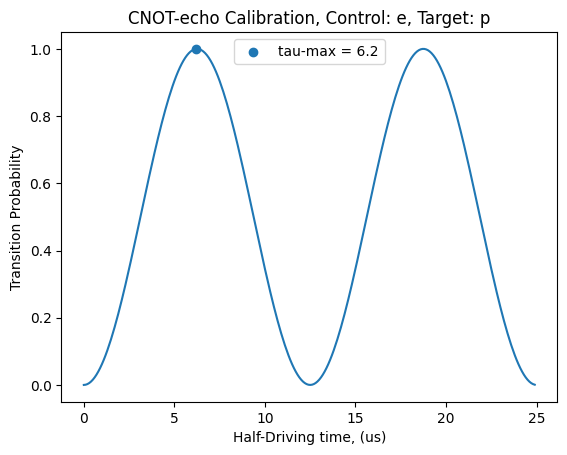

In [113]:
plt.plot(times, rhof_list)
t_cnot_nuc = times[np.argmax(rhof_list)]
plt.scatter(t_cnot_nuc, np.max(rhof_list),label=f"tau-max = {t_cnot_nuc}")
plt.xlabel("Half-Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT-echo Calibration, Control: e, Target: p")
plt.legend()
plt.show()

In [114]:
cnot_n = XPi * selective_lower(6.25 * us) * XPi * selective_upper(6.25 * us)

In [115]:
qt.unitarity(cnot_n)

0.9715896608402294

In [129]:
cnot_n

Quantum object: dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 9.99994928e-01-1.53683343e-21j  1.24892109e-03+1.28753178e-03j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.24892109e-03-1.28753178e-03j  3.50987445e-06+1.60488520e-21j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   7.81247978e-07+1.41117939e-25j -2.50044689e-16-4.97355740e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.50044690e-16+4.97355740e-07j  7.81249580e-07-1.13704321e-25j]
 [-1.24892109e-03+1.28753178e-03j  8.96471186e-01+2.01933372e-11j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.28807510e-08+3.39741584e-06j  1.24892109e-03-1.28753178e-03j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   4.09753548e

In [106]:
qt.to_super(qt.gates.cnot())

Quantum object: dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape=(16, 16), type='super', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

In [121]:
(1j*np.pi*(Iz)).expm()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]]

In [146]:
cnot_e

Quantum object: dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 9.99273375e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.64196766e-02-2.13604796e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.12494015e-10-9.13105689e-29j
   0.00000000e+00+0.00000000e+00j -1.98626964e-10-1.07278149e-11j
   1.64196766e-02+2.13604796e-02j  0.00000000e+00+0.00000000e+00j
   7.26623986e-04+5.13810485e-20j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.98626964e-10+1.07278149e-11j
   0.00000000e+00+0.00000000e+00j  3.12505985e-10+8.61863374e-29j]
 [ 0.00000000e+00+0.00000000e+00j -3.70839861e-06+6.19314493e-06j
   0.00000000e+00+0.00000000e+00j  6.09171481e-01-7.92558472e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.40829243e-09-1.65297674e-07j
   0.00000000e

In [148]:
np.arctan(0.793/0.609)/deg

52.47682811737924

In [82]:
swap = cnot_e*cnot_n*cnot_e

In [83]:
qt.unitarity(swap)

0.9711590964601092

In [84]:
qt.vector_to_operator(swap * qt.operator_to_vector(rho01))

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 7.27370443e-04-2.74427726e-19j  1.54563376e-13+3.29655354e-13j
  -2.13594471e-02+1.64118374e-02j -1.43700560e-09+1.21312359e-08j]
 [ 1.54565212e-13-3.29655164e-13j  1.57487215e-06-9.81549409e-29j
  -3.27593155e-12+2.69019399e-12j -1.07281866e-11-1.98624758e-10j]
 [-2.13594471e-02-1.64118374e-02j -3.27587327e-12-2.69015807e-12j
   9.99263976e-01+2.74427623e-19j -2.38295536e-10+2.48983996e-10j]
 [-1.43700560e-09-1.21312359e-08j -1.07281866e-11+1.98624758e-10j
  -2.38295536e-10-2.48983996e-10j  7.07832874e-06+6.21931683e-26j]]

In [86]:
qt.gates.swap()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

In [90]:
swap

Quantum object: dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 9.98542270e-01+9.95714679e-19j -4.21137967e-03-2.65376785e-02j
   2.13440091e-02+1.64000113e-02j  1.79137311e-03-2.13943073e-05j
  -4.21137967e-03+2.65376785e-02j  7.27370443e-04-2.74427726e-19j
  -5.25761084e-04+4.98476959e-04j -6.74789084e-06+5.12417767e-05j
   2.13440091e-02-1.64000113e-02j -5.25761084e-04-4.98476959e-04j
   7.26846638e-04-1.27148029e-18j  3.79544912e-05-2.99053523e-05j
   1.79137311e-03+2.13943073e-05j -6.74789084e-06-5.12417767e-05j
   3.79544912e-05+2.99053523e-05j  3.51307468e-06+1.60176659e-21j]
 [-4.21139844e-03-2.65376852e-02j  2.75571455e-07+5.05194676e-06j
  -4.76070954e-01+8.74963064e-01j  6.37730009e-06-3.24032262e-06j
   7.26709711e-04+2.28937682e-10j  1.54565212e-13-3.29655164e-13j
  -2.13654779e-02-1.64215820e-02j -1.34334290e-07+1.92749366e-08j
  -5.26164227e-04-4.98356526e-04j  5.10602590e-08+1.21751520e-07j
   4.21137226e

In [128]:
qt.to_super(qt.gates.iswap())

Quantum object: dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape=(16, 16), type='super', dtype=CSR, isherm=False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.

In [123]:
-0.476+0.875j

(-0.476+0.875j)

In [126]:
np.arctan(0.875/-0.476)/deg

-61.45380926895664

In [124]:
-0.849-0.523j

(-0.849-0.523j)

In [127]:
np.arctan(-0.523/-0.849)/deg

31.63385205429806